<p><a name="tree"></a></p>
# Decision Tree and Random Forest

- Similar to regression, we use the same procedure to fit a classification tree.

- For regression we used the RSS to determine the splitting,  what should we use for classification? Two commonly used metrics are:

  - gini impurity: $I_G(f) = \sum_{i=1}^m f_i(1-f_i)$

  - information gain: $I_E(f) = -\sum_{i=1}^m f_i \log_2(f_i)$
  
where $f_i$ is the fraction of items labeled with $i$ in the set and $\sum f_i = 1$.

In [1]:
from PlotFunctions import plot_model
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

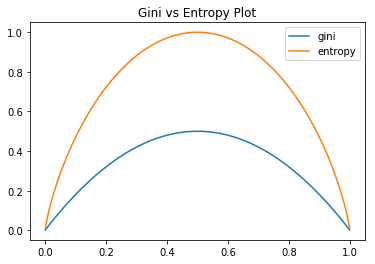

In [2]:
import math
x = np.linspace(start=.001, stop=.999, num=100)  # math.log won't accept 0 or 1
y1 = list(map(lambda i: 2 * i * (1 - i), x))
y2 = list(map(lambda t: -t * math.log(t, 2) - (1 - t) * math.log((1 - t), 2), x))

plt.plot(x, y1, label='gini')
plt.plot(x, y2, label='entropy')
plt.legend(loc=1)
plt.title('Gini vs Entropy Plot')
plt.show()

## The Above Plot Showcases the Gini vs Entropy for Two-Classes Classification
- The Gini and Entropy Plot for multi-class classification will be discussed in the Advanced Classification Lecture

<p><a name="2ex1"></a></p>
### Exercise : Gini impurity and Information Gain

- We will use the `purity` function defined below:

In [3]:
from collections import Counter
import math

def purity(L, metric='gini'):
    total = len(L)
    freq = map(lambda x: float(x) / total, list(Counter(L).values()))
    if metric == 'gini':
        scores = map(lambda x: x * (1 - x), freq)
    elif metric == 'entropy':
        scores = map(lambda x: -x * math.log(x, 2), freq)
    return sum(scores)

Suppose there are 10 people in a group, 5 male and 5 female. Their heights are listed below

5'2"|5'3"|5'5"|5'6"|5'6"|5'7"|5'7"|5'8"|5'10"|5'11"
-|-|-|-|-|-|-|-|-|-
f|f|f|f|m|f|m|m|m|m


L = ['f','f','f','f','m','f','m','m','m','m']
- What is the gini impurity?

In [4]:
#### Your code here

L = ['f', 'f', 'f', 'f', 'm', 'f', 'm', 'm', 'm', 'm']
gini = purity(L)
print(gini)

0.5


- If we split the group from the middle (between 5'6" and 5'7") into 
  - L1 = ['f','f','f','f','m'], and 
  - L1 = ['f','m','m','m','m'],
  what is the weighted sum of gini impurity? And what is the change of gini impurity before and after splitting?

In [5]:
#### Your code here

gini_split = 0.5 * purity(L[:5]) + 0.5 * purity(L[5:])
print(gini_split)
print(gini - gini_split)

0.32
0.18


- Try different cutpoints to see which points gives the maximum difference? How can we use this cutpoint for our prediction? 

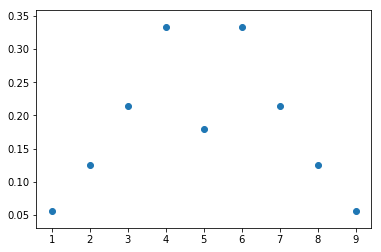

In [6]:
import matplotlib.pyplot as plt
x = range(1, len(L))
func = lambda i: gini - i * purity(L[:i]) / len(L) - (len(L) - i) * purity(L[i:]) / len(L)
y = list(map(func, x))
plt.scatter(x, y)
plt.show()

## Decision Tree in Scikit Learn

The function **tree.DecisionTreeClassifier** in sklearn can be used to implement decision tree.

In [7]:
from sklearn import tree
tree_model = tree.DecisionTreeClassifier()

### Arguments:

- **criterion**: "gini" or "entropy", corresponding to the criteria of "gini impurity" and "information gain". default = 'gini'.

- **max_depth**: The maximum depth of the tree. default = None, which means the nodes will be expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

- **min_samples_split**: The minimum number of samples required to split. default = 2.

- **min_samples_leaf **: The minimum number of samples required to be at a terminate node. default = 1.

### Methods:

- **fit**: Build a decision tree from the training set (X, y).

- **predict**: 	Predict class or regression value for X.

- **predict_log_proba**	Predict class log-probabilities of the input samples X.

- **predict_proba**	Predict class probabilities of the input samples X.

- **score**:	Return the mean accuracy on the given test data and labels.

- **set_params**:	Set the parameters of this estimator.

- **get_params**: Get parameters for this estimator.

### Attributes:

- **tree\_**: Tree object, the underlying tree object.

- **feature\_importances\_**: The feature importances. The higher, the more important the feature. Also known as gini importance.

<p><a name="2case1"></a></p>
### Case 1: Iris Data

We use all the observations and the last two features, "petal length" and "petal width", in the iris data to build a decision-tree.

In [8]:
from sklearn import datasets
iris = datasets.load_iris()
tree_model.fit(iris.data[:, 2:4], iris.target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

We can find the performance of the model and the importance of each feature. 

In [9]:
## We can see that the performance of decision tree is amazingly good!
tree_model.score(iris.data[:, 2:4], iris.target)

0.9933333333333333

In [10]:
print(tree_model.feature_importances_)

[0.57167834 0.42832166]


We visualize the decision boundary of the tree:

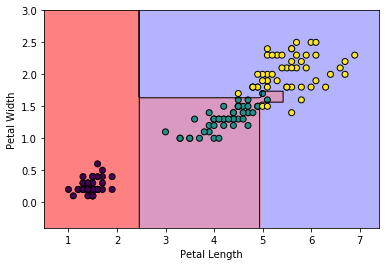

In [11]:
plot_model(tree_model, iris.data[:, 2], iris.data[:, 3], iris.target)
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.show()

- A classification tree estimates its class probabilities as locally constant functions over rectangular domains
- The major difference from a regression tree is that it does not use MSE/RSS as its gauge

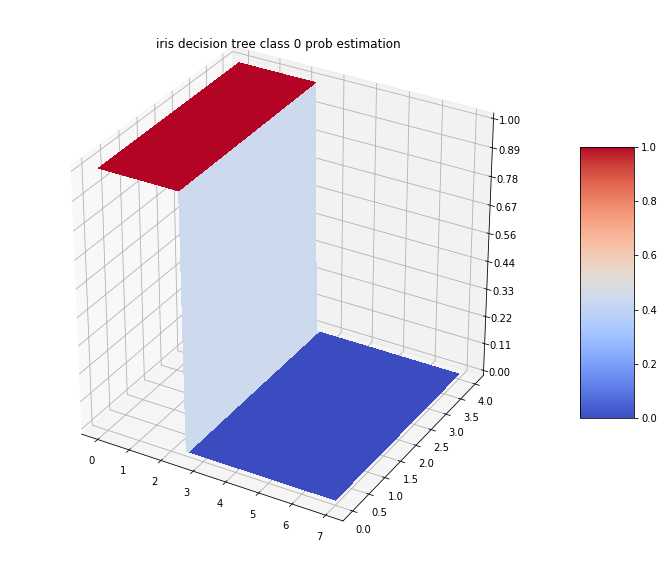

In [12]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
plt.rcParams['figure.figsize'] = (12,10)
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
A = np.linspace(0,7,100)
B = np.linspace(0,4,100)
A, B = np.meshgrid(A, B)

C = tree_model.predict_proba(np.transpose(np.array([A.flatten(), B.flatten()])))[:,0].reshape((100,100))
# Plot the surface.
surf = ax.plot_surface(A, B, C, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title(r'iris decision tree class 0 prob estimation')
plt.show()

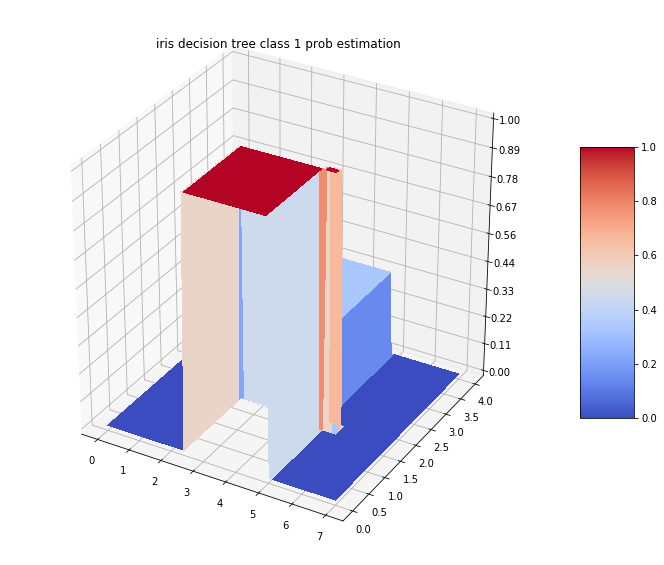

In [13]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
plt.rcParams['figure.figsize'] = (12,10)
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
A = np.linspace(0,7,100)
B = np.linspace(0,4,100)
A, B = np.meshgrid(A, B)

C = tree_model.predict_proba(np.transpose(np.array([A.flatten(), B.flatten()])))[:,1].reshape((100,100))
# Plot the surface.
surf = ax.plot_surface(A, B, C, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title(r'iris decision tree class 1 prob estimation')
plt.show()

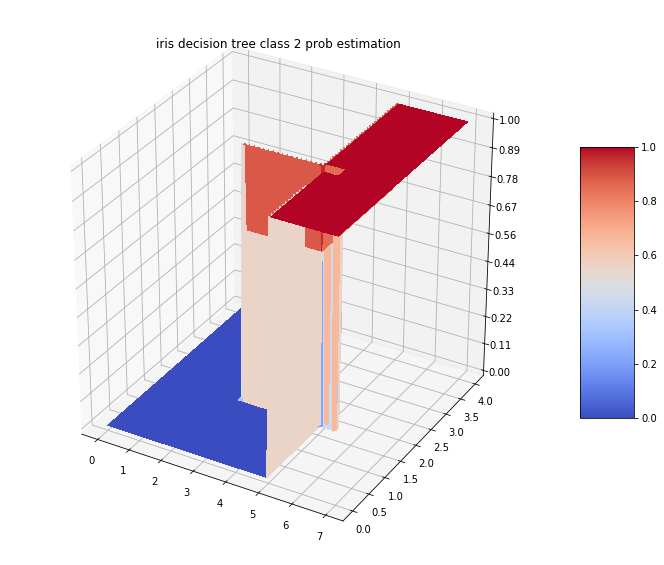

In [14]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
plt.rcParams['figure.figsize'] = (12,10)
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
A = np.linspace(0,7,100)
B = np.linspace(0,4,100)
A, B = np.meshgrid(A, B)

C = tree_model.predict_proba(np.transpose(np.array([A.flatten(), B.flatten()])))[:,2].reshape((100,100))
# Plot the surface.
surf = ax.plot_surface(A, B, C, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title(r'iris decision tree class 2 prob estimation')
plt.show()

In [15]:
# need to have the dot executable and graphviz first
# http://www.graphviz.org/Download.php
# https://pypi.python.org/pypi/graphviz
# Then call
tree.export_graphviz(tree_model, out_file='tree.dot') 
!dot -Tpng tree.dot -o tree.png

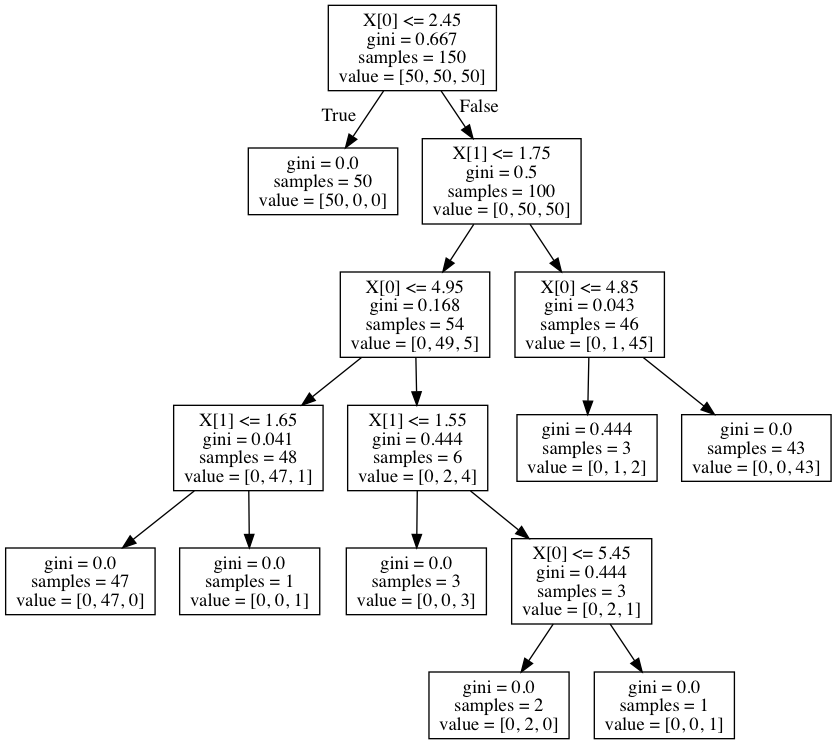

In [16]:
from IPython.display import Image
Image(filename='tree.png')

<p><a name="2case2"></a></p>
### Case 2: Spam Filter

In this case we try to fit a decision tree on the spam data set.

In [17]:
# prepare data 
import pandas as pd
import numpy as np
train = pd.read_csv('data/spam_train.csv')
test = pd.read_csv('data/spam_test.csv')
## separate the predictors and response in the training data set
x_train = np.array(train.iloc[:, 0:57])
y_train = np.ravel(train.iloc[:, -1])
## separate the predictors and response in the test data set
x_test = np.array(test.iloc[:, 0:57])
y_test = np.ravel(test.iloc[:, -1])
train.columns

Index(['A.1', 'A.2', 'A.3', 'A.4', 'A.5', 'A.6', 'A.7', 'A.8', 'A.9', 'A.10',
       'A.11', 'A.12', 'A.13', 'A.14', 'A.15', 'A.16', 'A.17', 'A.18', 'A.19',
       'A.20', 'A.21', 'A.22', 'A.23', 'A.24', 'A.25', 'A.26', 'A.27', 'A.28',
       'A.29', 'A.30', 'A.31', 'A.32', 'A.33', 'A.34', 'A.35', 'A.36', 'A.37',
       'A.38', 'A.39', 'A.40', 'A.41', 'A.42', 'A.43', 'A.44', 'A.45', 'A.46',
       'A.47', 'A.48', 'A.49', 'A.50', 'A.51', 'A.52', 'A.53', 'A.54', 'A.55',
       'A.56', 'A.57', 'spam'],
      dtype='object')

Fit on the training data directly:

In [18]:
tree_model.fit(x_train, y_train)
train_error = (1 - tree_model.score(x_train, y_train))
test_error = (1 - tree_model.score(x_test, y_test))
print("The training error is: %.5f" %train_error)
print("The test     error is: %.5f" %test_error)

The training error is: 0.00043
The test     error is: 0.10083


- The training error here is also very low.
- The test error, however, is significantly higher than the training error.
- Despite the differences in error, decision tree performs quite well compared to other models.

The decision tree returns importance. We see that there a lot of features with zero importance, which allow feature selection.

In [19]:
feature_importance = tree_model.feature_importances_
print([t[1] for t in zip(feature_importance, train.columns) if t[0]>0])
feature_importance

['A.1', 'A.2', 'A.3', 'A.5', 'A.6', 'A.7', 'A.8', 'A.9', 'A.10', 'A.11', 'A.12', 'A.14', 'A.16', 'A.17', 'A.18', 'A.19', 'A.20', 'A.21', 'A.23', 'A.24', 'A.25', 'A.26', 'A.27', 'A.28', 'A.29', 'A.30', 'A.36', 'A.37', 'A.39', 'A.42', 'A.43', 'A.45', 'A.46', 'A.49', 'A.50', 'A.51', 'A.52', 'A.53', 'A.54', 'A.55', 'A.56', 'A.57']


array([0.00185947, 0.00181929, 0.00121286, 0.        , 0.01242953,
       0.0037654 , 0.17003175, 0.00776688, 0.00327421, 0.01621837,
       0.00728697, 0.00201421, 0.        , 0.00052926, 0.        ,
       0.02773903, 0.00544088, 0.00631437, 0.01736266, 0.00052557,
       0.01830692, 0.        , 0.0099444 , 0.00792525, 0.0684364 ,
       0.00212251, 0.00526269, 0.00256949, 0.00175088, 0.00136447,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00236383, 0.00361791, 0.        , 0.0120713 , 0.        ,
       0.        , 0.00517029, 0.00355416, 0.        , 0.01119173,
       0.01632913, 0.        , 0.        , 0.00284619, 0.01591486,
       0.00349707, 0.0865099 , 0.3220033 , 0.00143757, 0.03633412,
       0.02314109, 0.05074381])

<p><a name="2case3"></a></p>
### Case 3: Grid Search 

- Since the test error is much higher than training error, the model may overfit the training data.
- Use cross-validation to find out the best parameters and evaluate the model.

In [20]:
from sklearn.model_selection import GridSearchCV
grid_para_tree = [{
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": range(1, 10),
    "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int)
}]
tree_model.set_params(random_state=108)
grid_search_tree = GridSearchCV(tree_model, grid_para_tree, cv=5, scoring='accuracy', n_jobs=-1)
%time grid_search_tree.fit(x_train, y_train)

CPU times: user 2.71 s, sys: 104 ms, total: 2.81 s
Wall time: 8.21 s


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=108,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'criterion': ['gini', 'entropy'], 'min_samples_leaf': range(1, 10), 'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [21]:
## best parameters
grid_search_tree.best_params_

{'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 30}

In [22]:
## best score
grid_search_tree.best_score_

0.9143478260869565

- The best "min_samples_split" is 30 here, while the default value is 2, which may overfit the training data and underestimate the test error.
- It is necessary to use cross-validation method to choose the parameters.

In [23]:
## The overall accuracy on the training set:
grid_search_tree.score(x_train, y_train)

0.9543478260869566

In [24]:
## The overall accuracy on the test set:
grid_search_tree.score(x_test, y_test)

0.9074315514993481

<p><a name="2case4"></a></p>
### Case 4: Depth of Tree

- The code below displays the learning curve. The training and the testing error are plotted against the depth of the trees.

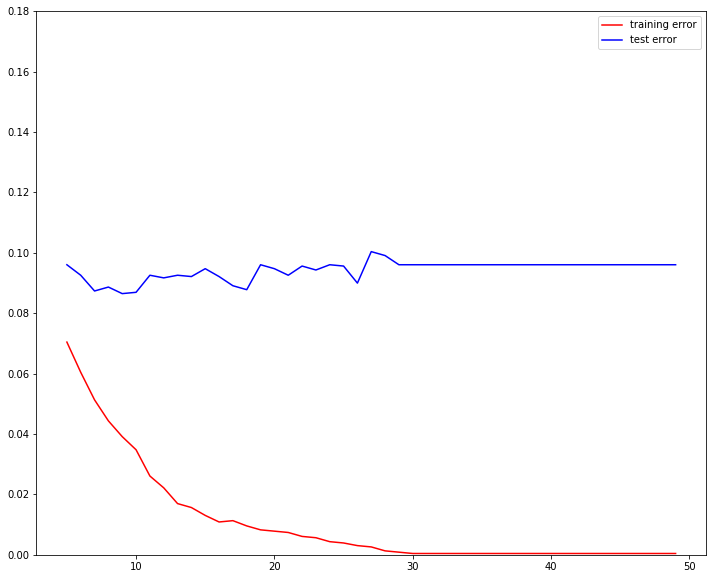

In [25]:
depth = range(5, 50)
train_error = []
test_error = []
for i in depth:
    tree_model.set_params(max_depth=i, min_samples_leaf=1)
    tree_model.fit(x_train, y_train)
    train_error.append(1 - tree_model.score(x_train, y_train))
    test_error.append(1 - tree_model.score(x_test, y_test))

import matplotlib.pyplot as plt
plt.plot(depth, train_error, c='red', label='training error')
plt.plot(depth, test_error, c='blue', label='test error')
plt.ylim(0, 0.18)
plt.legend()
plt.show()

As the depth of the tree increase:

- The training error goes down.
- The test error does not change too much.
- For interpretability, it's better to choose a smaller tree.

### Decision Trees Pros and Cons

- Pros:
  - Interpretability: easier to explain than most other regression methods.
  - Easy to handle qualitative predictors.
  - Can be displayed graphically.
- Cons:
  - Instability: a small change in the data may result in a huge different splits.
  - Predictive accuracy usually not as good as other approaches.
- By aggregating many decision trees, the predictive performance can be improved substantially.


<p><a name="rf"></a></p>
## Random Forest in Scikit Learn

### Bagging

By averaging a collection of bootstrap (repeated) samples from the training data set, we can dramatically reduce the variance of trees, leading to improved prediction, this is called bagging.

- generate B bootstrapped training dataset.

- for each test observation, we record the class predicted by each of the B trees, and choose the majority

- the overall prediction is the most commonly occurring class among the B predictions.



The function **ensemble.RandomForestClassifier** in library sklean can be used to implement random forest.

In [26]:
from sklearn import ensemble
from sklearn.datasets import load_iris
randomForest = ensemble.RandomForestClassifier()
bagging      = ensemble.BaggingClassifier()
iris = load_iris()
#dir(ensemble)
randomForest?

### Arguments

Since random forest is combined by decision trees, it also has the arguments of tree: 

- **criterion** : default=”gini”.
- **max_depth**: default = None.
- **min_samples_split**: default = 2.
- **min_samples_leaf**: default = 1.
- **n_estimators**: The number of trees. default=100.
- **bootstrap**: Whether bootstrap samples are used when building trees. default=true.
- **oob_score**: Whether to use out-of-bag samples to estimate the generalization error. default=false.

### Methods

- **fit**: Build a forest of trees from the training set (X, y).
- **score**: Return the mean accuracy on the given test data and labels.
- **predict**: Predict class for X.
- **predict_log_proba**: Predict class log-probabilities for X.
- **predict_proba**: Predict class probabilities for X.
- **set_params**: Set the parameters of this estimator.
- **get_params**: Get parameters for this estimator.

### Attributes

- **feature\_importances\_**:The feature importances (the higher, the more important the feature).

- **oob\_score\_**: Score of the training dataset obtained using an out-of-bag estimate.

<p><a name="3case1"></a></p>
### Case 1: Iris Data

We use all the observations and the last two features, "petal length" and "petal width", in the iris data to build a decision-tree.

In [27]:
randomForest.set_params(random_state=42, n_estimators=100, max_features=2)
randomForest.fit(iris.data[:, 2:4], iris.target) # fit 
randomForest.score(iris.data[:, 2:4], iris.target) # accuracy

0.9933333333333333

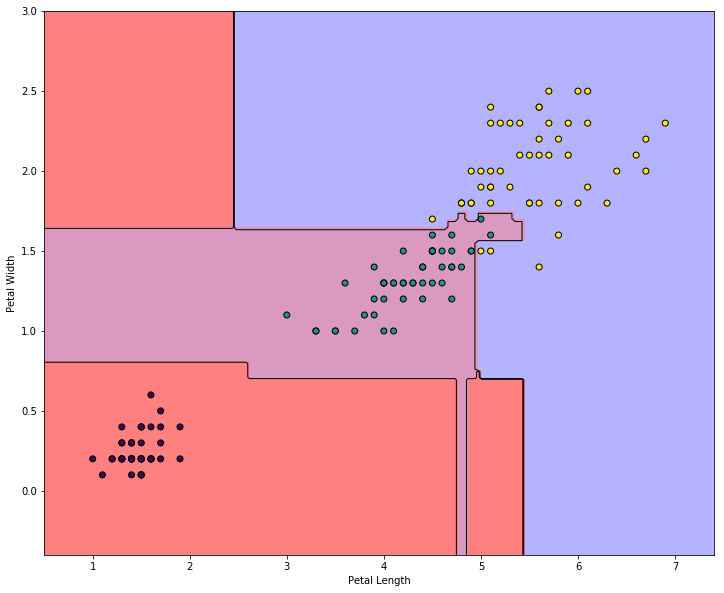

In [28]:
plot_model(randomForest, iris.data[:, 2], iris.data[:, 3], iris.target)
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.show()

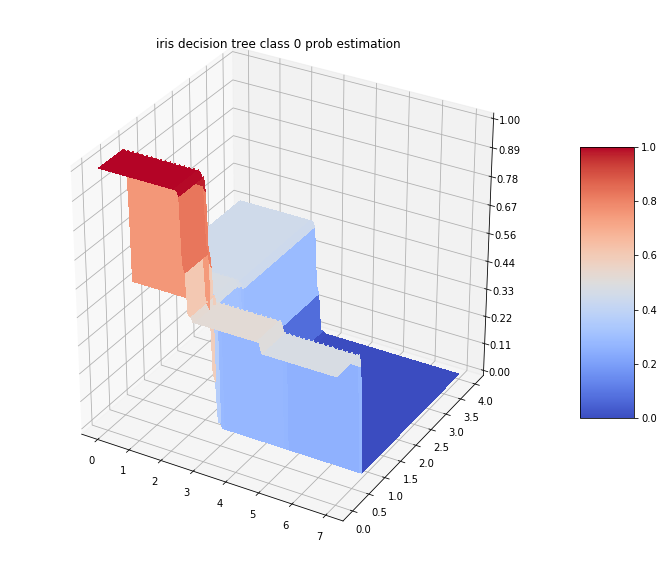

In [29]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
plt.rcParams['figure.figsize'] = (12,10)
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
A = np.linspace(0,7,100)
B = np.linspace(0,4,100)
A, B = np.meshgrid(A, B)

C = randomForest.predict_proba(np.transpose(np.array([A.flatten(), B.flatten()])))[:,0].reshape((100,100))
# Plot the surface.
surf = ax.plot_surface(A, B, C, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title(r'iris decision tree class 0 prob estimation')
plt.show()

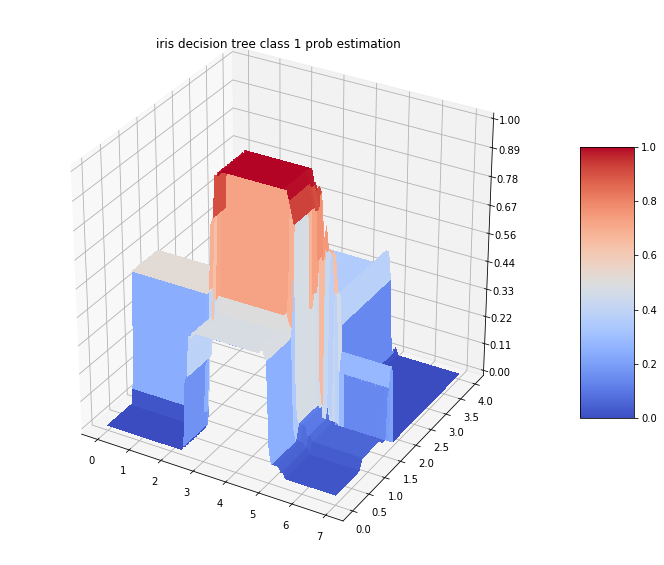

In [30]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
plt.rcParams['figure.figsize'] = (12,10)
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
A = np.linspace(0,7,100)
B = np.linspace(0,4,100)
A, B = np.meshgrid(A, B)

C = randomForest.predict_proba(np.transpose(np.array([A.flatten(), B.flatten()])))[:,1].reshape((100,100))
# Plot the surface.
surf = ax.plot_surface(A, B, C, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title(r'iris decision tree class 1 prob estimation')
plt.show()

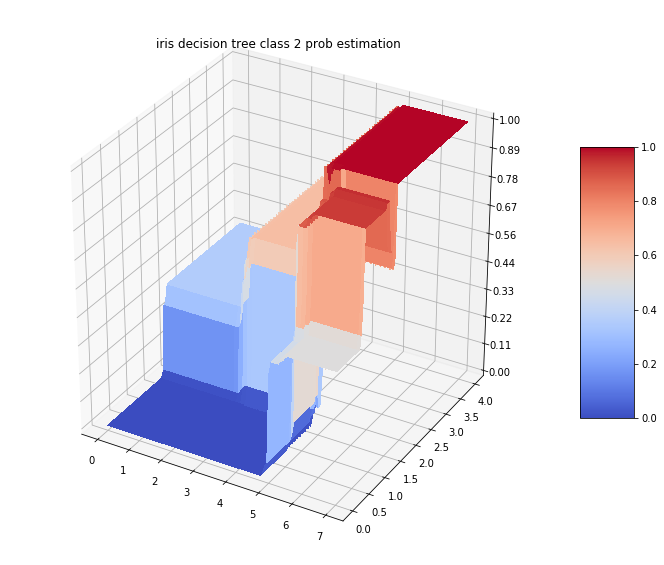

In [31]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
plt.rcParams['figure.figsize'] = (12,10)
fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
A = np.linspace(0,7,100)
B = np.linspace(0,4,100)
A, B = np.meshgrid(A, B)

C = randomForest.predict_proba(np.transpose(np.array([A.flatten(), B.flatten()])))[:,2].reshape((100,100))
# Plot the surface.
surf = ax.plot_surface(A, B, C, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title(r'iris decision tree class 2 prob estimation')
plt.show()

The boundary of random forest is highly non-linear and hard to interpret.

<p><a name="3case2"></a></p>
### Case 2: Spam Filter

In this case we fit a random forest on the spam data. We first prepare the data:

In [32]:
import pandas as pd
from sklearn import model_selection
spam_train = pd.read_csv('./data/spam_train.csv')
spam_test = pd.read_csv('./data/spam_test.csv')
x_train = np.array(spam_train.iloc[:, :57])
y_train = np.array(spam_train.iloc[:, -1])
x_test = np.array(spam_test.iloc[:, :57])
y_test = np.array(spam_test.iloc[:, -1])

## Comparing Bagging and Random Forest
- Bagging (at least in this example) has a lower test performance 
- But at the individual tree level, it has a better performance than the trees in a random forest

In [33]:
bagging.set_params(n_estimators=50, random_state=42, max_features=57)
bagging.fit(x_train, y_train)
print("The training error of bagging forest is: %.5f" %(1 - bagging.score(x_train, y_train)))
print("The test     error of bagging forest is: %.5f" %(1 - bagging.score(x_test, y_test)))

The training error of bagging forest is: 0.00087
The test     error of bagging forest is: 0.07388


In [34]:
mistakes = 0  # the mistakes each individual tree makes
confusion_pair = 0 # the difference of all pairs of 

n_pairs = 0.5* bagging.n_estimators * (bagging.n_estimators-1)

for idx, tree in enumerate(bagging.estimators_):
       mistakes += confusion_matrix(tree.predict(x_test), y_test=='spam')    
       for idx2, tree2 in enumerate(bagging.estimators_):
            if idx2 == idx: continue
            confusion_pair += confusion_matrix(tree.predict(x_test), tree2.predict(x_test))   
print("Average per Tree Confusion")
print(mistakes/bagging.n_estimators*1.0)
print("Aggregate Pairwise Confusion")
print(confusion_pair/n_pairs)

Average per Tree Confusion
[[1263.58  125.76]
 [ 135.42  776.24]]
Aggregate Pairwise Confusion
[[2498.0555102  280.6244898]
 [ 280.6244898 1542.6955102]]


In [35]:
randomForest.set_params(n_estimators=50, random_state=42, max_features=10)
randomForest.fit(x_train, y_train)
print("The training error of random forest is: %.5f" %(1 - randomForest.score(x_train, y_train)))
print("The test     error of random forest is: %.5f" %(1 - randomForest.score(x_test, y_test)))

The training error of random forest is: 0.00043
The test     error of random forest is: 0.05693


In [36]:
mistakes = 0 # the mistakes each individual tree makes
confusion_pair = 0
n_pairs = 0.5 * randomForest.n_estimators * (randomForest.n_estimators-1)
for idx, tree in enumerate(randomForest.estimators_):
       mistakes += confusion_matrix(tree.predict(x_test), y_test=='spam')
       for idx2, tree2 in enumerate(randomForest.estimators_):
            if idx2 == idx: continue
            confusion_pair += confusion_matrix(tree.predict(x_test), tree2.predict(x_test))   
print("Average per Tree Confusion:")
print(mistakes/randomForest.n_estimators*1.0)
print("Aggregate Pairwise Confusion:")
print(confusion_pair/n_pairs)

Average per Tree Confusion:
[[1248.64  127.6 ]
 [ 150.36  774.4 ]]
Aggregate Pairwise Confusion:
[[2408.88816327  343.59183673]
 [ 343.59183673 1505.92816327]]


### Feature Importance of Random Forest

- We then sort the features by importance:

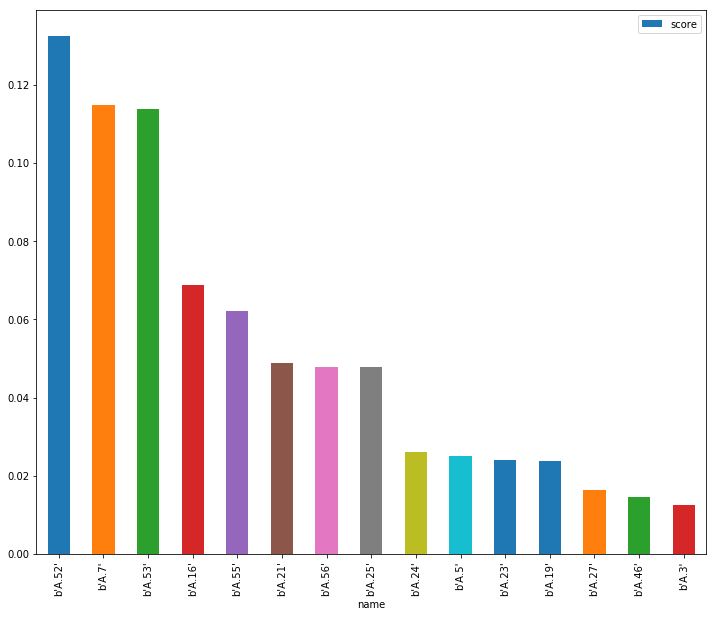

In [37]:
feature_importance = list(zip(spam_train.columns[:-2], randomForest.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance = np.array(feature_importance, dtype=dtype)
feature_sort = np.sort(feature_importance, order='importance')[::-1]
name, score = zip(*list(feature_sort))
pd.DataFrame({'name':name,'score':score})[:15].plot.bar(x='name', y='score')

In [38]:
print(randomForest.n_estimators)
randomForest.estimators_


50


[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=10, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=1608637542, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=10, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=1273642419, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features=10, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fractio

## Display the Trees within the Ensemble in the Jupyter Notebook 
- One can see explicitly how large are the trees
- Specify a treeIdx within the valid range $[0, 50)$

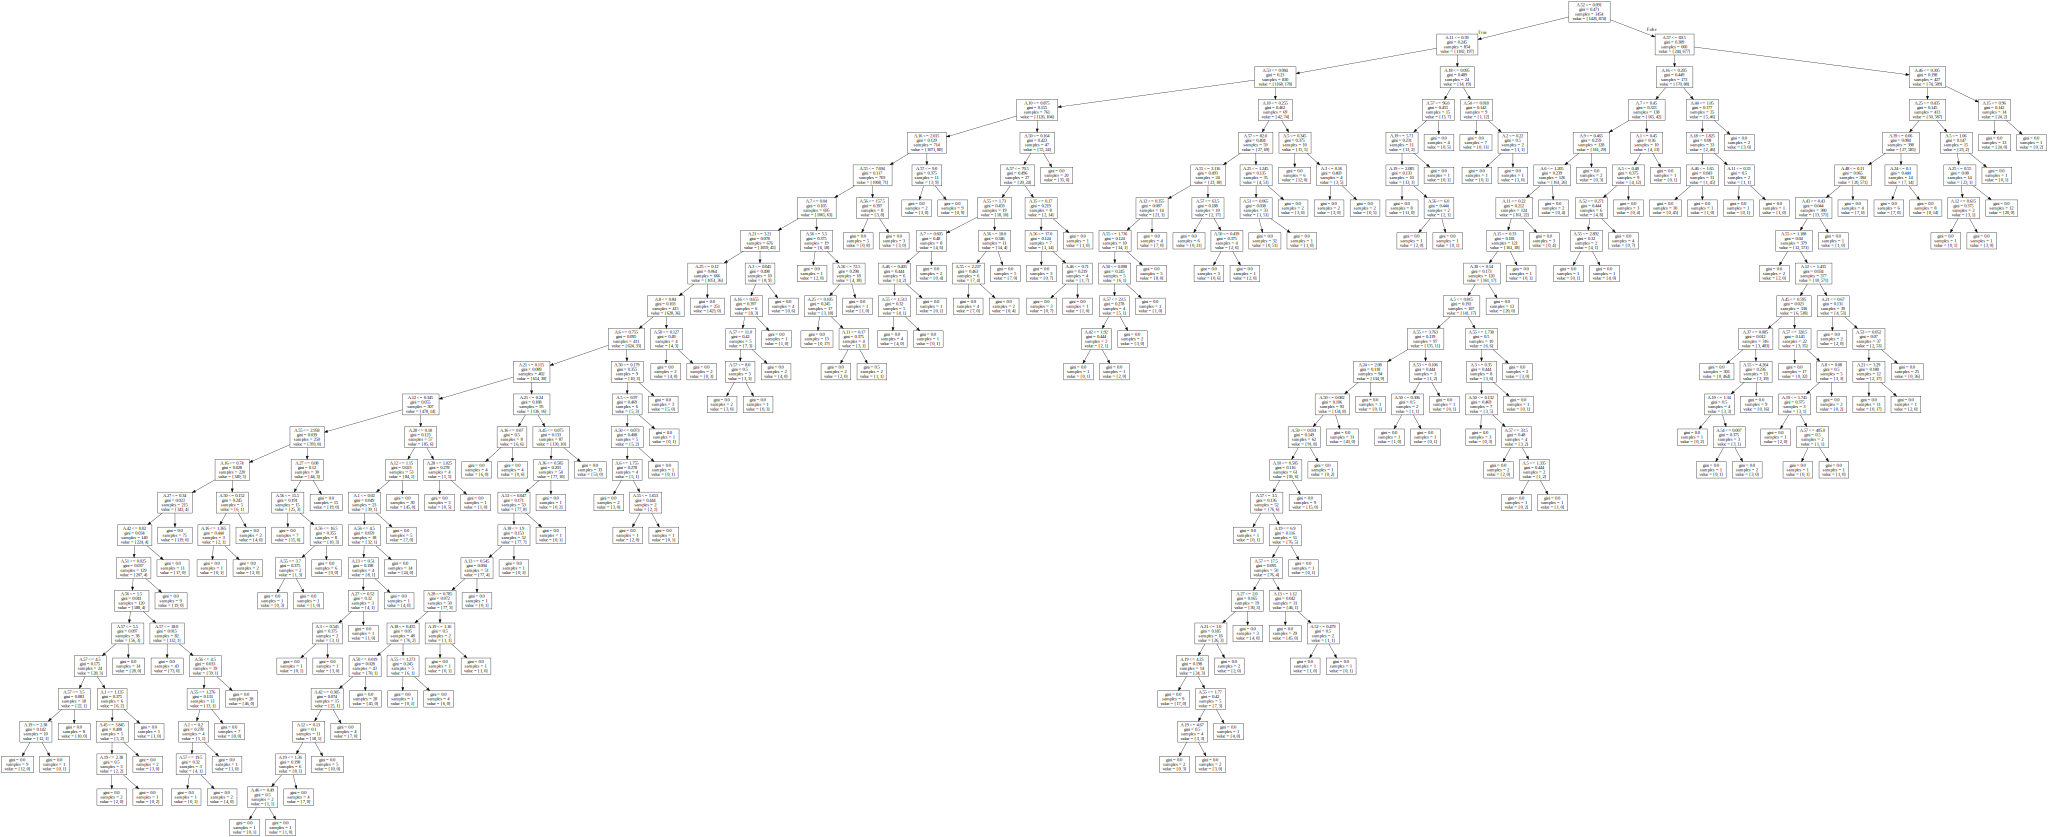

In [39]:
from graphviz import Source
from sklearn import tree
from IPython.display import SVG
treeIdx = 40 # has to be less than 50

graph = Source(tree.export_graphviz(randomForest.estimators_[treeIdx], out_file=None, feature_names=spam_train.columns[:57]))
SVG(graph.pipe(format='svg'))

### OOB-Score

- oob-score is the *out of bag* score, which is also used to evaluate the model.
- After fitting on the bootstrap sample, it makes predictions on the rest of the data set(out of the bootstrap sample).
- We can not control the numbers of observations in the out of bag sample.

We need to set *oob-score=true* manually when fit the model:

In [40]:
randomForest.set_params(oob_score=True, random_state=42)
randomForest.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [41]:
randomForest.oob_score_

0.94

<p><a name="3case3"></a></p>
### Case 3: Grid Search

As for decision tree, we also need to decide several parameters by grid search. It might take longer for this one.

In [42]:
grid_para_forest = [{
    "n_estimators": [25, 50, 100],
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": range(1, 10),
    "min_samples_split": np.linspace(start=2, stop=30, num=15, dtype=int),
    "random_state": [42]}]
grid_search_forest = GridSearchCV(randomForest, grid_para_forest, scoring='accuracy', cv=5, n_jobs=-1)
%time grid_search_forest.fit(x_train, y_train)

CPU times: user 20 s, sys: 597 ms, total: 20.6 s
Wall time: 3min 57s


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'n_estimators': [25, 50, 100], 'random_state': [42], 'criterion': ['gini', 'entropy'], 'min_samples_leaf': range(1, 10), 'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [43]:
grid_search_forest.best_params_

{'criterion': 'entropy',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100,
 'random_state': 42}

In [44]:
grid_search_forest.best_score_

0.9456521739130435

In [45]:
print("The training error is: %.5f" % (1 - grid_search_forest.score(x_train, y_train)))
print("The test     error is: %.5f" % (1 - grid_search_forest.score(x_test, y_test)))

The training error is: 0.00043
The test     error is: 0.05476


<p><a name="3case4"></a></p>
### Case 4: Number of Trees

- We plot the errors against the number of trees:

In [46]:
n_trees_range = range(30, 500, 10)  # OOB score will warning if too few trees
train_error2 = []
test_error2 = []
oob_error = []

for n_trees in n_trees_range:
    randomForest.set_params(n_estimators=n_trees, random_state=42, oob_score=True)
    randomForest.fit(x_train, y_train)
    train_error2.append(1 - randomForest.score(x_train, y_train))
    test_error2.append(1 - randomForest.score(x_test, y_test))
    oob_error.append(1 - randomForest.oob_score_)

We see that
- The OOB error is very close to the test error.
- The training error is much smaller than the OOB error and the test error.

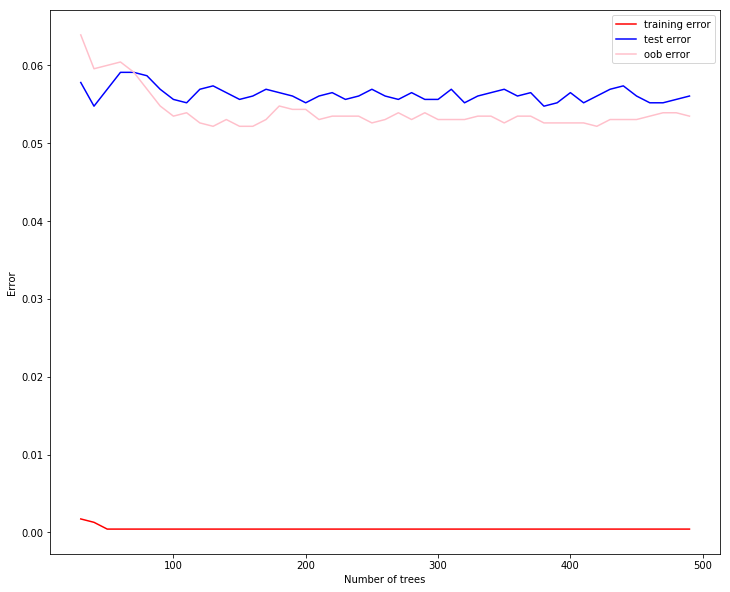

In [47]:
import matplotlib.pyplot as plt
plt.plot(n_trees_range, train_error2, c='red', label='training error')
plt.plot(n_trees_range, test_error2, c='blue', label='test error')
plt.plot(n_trees_range, oob_error, c='pink', label='oob error')
plt.ylabel('Error')
plt.xlabel('Number of trees')
plt.legend()
plt.show()

## Does it Make Sense to Use OOB Score to Estimate Test Error?
- For a smaller number of trees, the **oob** error differ sustaintially from the test error
- Thus one cannot **always** use the **oob** error score to estimate test error without knowing in advance when the difference is smaller enough

## Pros and Cons of Random Forests
**Strengths** of Random Forest:
- An all-purpose model that performs well on most problems.
- Can be used on data with an extremely large number of features. And it automatically selects the most important features.
- High accuracy.

**Weaknesses** of Random Forest:
- Unlike a decision tree, the model is hard to interpret.
- May require some work to tune the parameters.
